In [1]:
import cvxpy as cp
from cvxpy import *
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import time
import csv

In [2]:
# see files without loading
sio.whosmat('Reg_signals.mat')

[('RegA_May04', (21601, 1), 'double'),
 ('RegA_May05', (21601, 1), 'double'),
 ('RegA_May06', (21601, 1), 'double'),
 ('RegA_May07', (21601, 1), 'double'),
 ('RegA_May08', (21601, 1), 'double'),
 ('RegA_May09', (21601, 1), 'double'),
 ('RegA_May10', (21601, 1), 'double'),
 ('RegD_May04', (21601, 1), 'double'),
 ('RegD_May05', (21601, 1), 'double'),
 ('RegD_May06', (21601, 1), 'double'),
 ('RegD_May07', (21601, 1), 'double'),
 ('RegD_May08', (21601, 1), 'double'),
 ('RegD_May09', (21601, 1), 'double'),
 ('RegD_May10', (21601, 1), 'double')]

In [3]:
regD_mat = sio.loadmat('Reg_signals.mat')

In [4]:
regD_ar = regD_mat["RegD_May04"]
type(regD_ar)
np.shape(regD_ar)

(21601, 1)

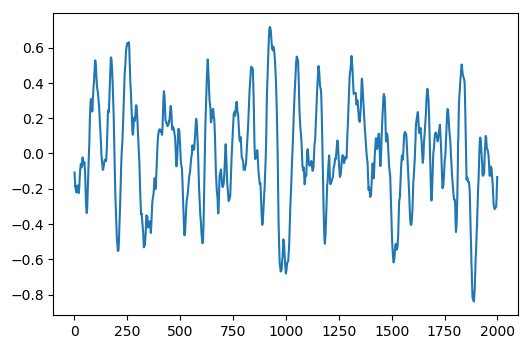

In [5]:
# plot regD
plt.figure(300, dpi=100)
plt.plot(regD_ar[0:2000])
plt.show()

In [6]:
# mobile ESS parameters
T = 240;
# T = 5;
L = 0.02; # MW
E_max = L*T
# E_max = L
P_max = E_max
# charge is denoted by negative sign
# E_init = -E_max/2
E_init = 0
assert E_init <=0, "E_init is positive"
lam_c = 50; # $/MWh
lam_mis = 5 # $/MWh
regD = regD_ar[0:T]
# T = np.shape(regD)[0]
#  define the subtraction matrix
Add_mat = np.tril(np.ones((T,T)))#, dtype=int))
if np.sign(E_init) == np.sign(regD[0]):
    print('E_init and RegD start with the same sign')
elif E_init == 0:
    print('E_init = 0')
else: print('Different signs')


E_init = 0


In [7]:
# print(Add_mat*Bt.value[0:5])
print('Add*Bt: ',np.shape(Add_mat*Bt.value))
print('Add dot Bt: ',np.shape(np.dot(Add_mat,Bt.value)))
print('Add@Bt: ',np.shape(Add_mat@Bt.value))
print('Bt: ',np.shape(Bt.value))

NameError: name 'Bt' is not defined

In [8]:
# Bt is discharge - charge
t0 = time.time()
Bt = cp.Variable((T, 1))
epsilon = cp.Variable((T, 1))
# ob = cp.Variable()
objective = cp.Minimize(sum(abs(epsilon)))
# objective = cp.Minimize(np.max(np.dot(Sub_mat,Xt)))
# objective = cp.Minimize(np.max(np.multiply(Sub_mat,Xt)))
constraints = [abs(Bt-L*regD) <= epsilon,
#                Bt[0] == E_init,
               -P_max <= Bt,
               Bt <= P_max,
              Add_mat@(-Bt) + E_init <= E_max,
              0*E_max <= Add_mat@(-Bt)]
#               0*E_max <= Add_mat@(-Bt),
#                Add_mat@(-Bt) <= E_max]

prob = cp.Problem(objective, constraints)
prob.solve()  # Returns the optimal value.
t1 = time.time()
print('Elapsed time:',t1-t0)
print("status:", prob.status)
print("optimal value", prob.value)
# print("optimal var", Bt.value)

Elapsed time: 0.14241886138916016
status: optimal
optimal value 0.35307567207310964


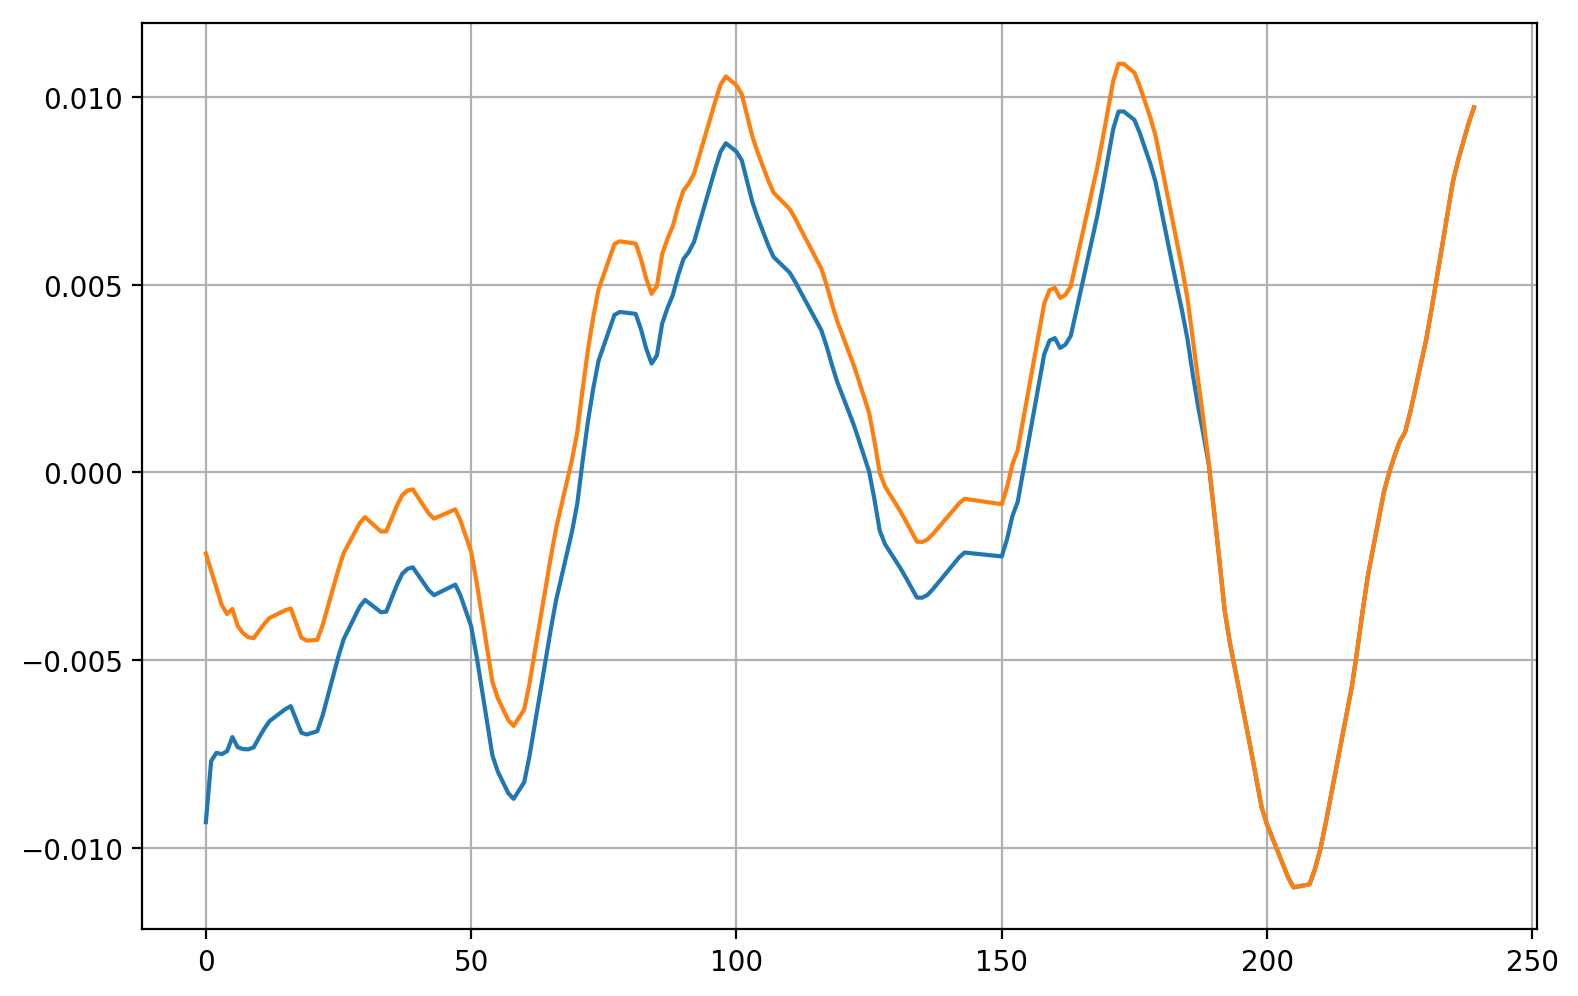

In [9]:
fig2 = plt.figure(100, figsize=(9, 6), dpi=200, facecolor='w', edgecolor='k')
plt.plot(Bt.value)
# plt.plot(Bt.value-L*regD)
plt.plot(L*regD)
plt.grid(True)
plt.show()

In [10]:
mis_pen = lam_mis*np.sum(np.abs(Bt.value - L*regD));
serv_ben = lam_c*L*30 - mis_pen # each 10 time intervals correspond to an hour
print("Mismatch penalty is: ",mis_pen)
print("Benefit is: ",serv_ben)

Mismatch penalty is:  1.7653783602792694
Benefit is:  28.234621639720732


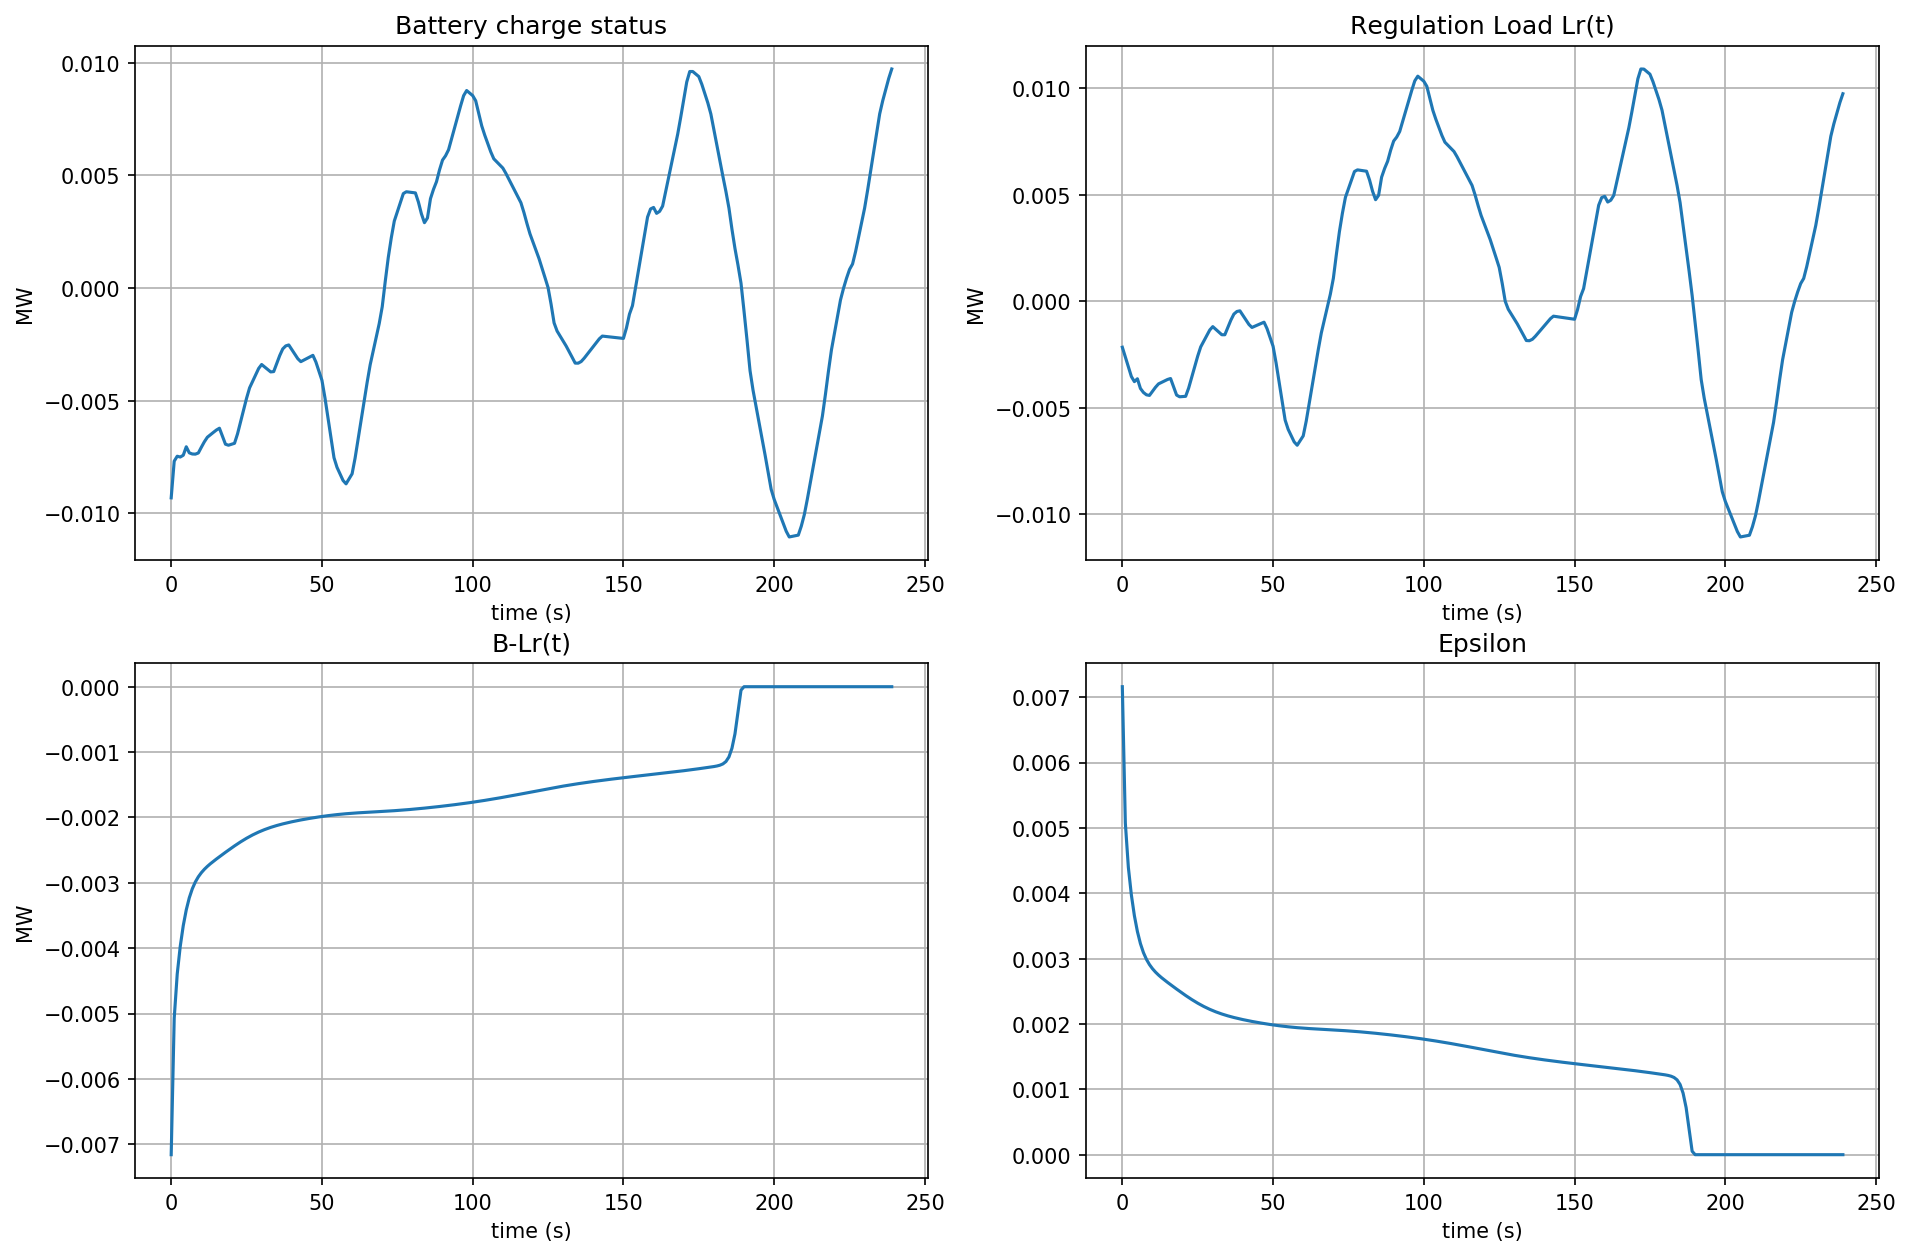

In [13]:
fig = plt.figure(200, dpi=150)
fig.subplots_adjust(hspace=0.2, wspace=0.2)
fig.set_figheight(10)
fig.set_figwidth(15)
plt.subplot(221)
plt.plot(Bt.value)
plt.xlabel('time (s)')
plt.ylabel('MW')
plt.title('Battery charge status')
plt.grid(True)

plt.subplot(222)
plt.plot(L*regD)
plt.xlabel('time (s)')
plt.ylabel('MW')
plt.title('Regulation Load Lr(t)')
plt.grid(True)

plt.subplot(223)
plt.plot(Bt.value - L*regD)
plt.xlabel('time (s)')
plt.ylabel('MW')
plt.title('B-Lr(t)')
plt.grid(True)

plt.subplot(224)
plt.plot(epsilon.value)
plt.xlabel('time (s)')
# plt.ylabel('MW')
plt.title('Epsilon')
plt.grid(True)

plt.show()

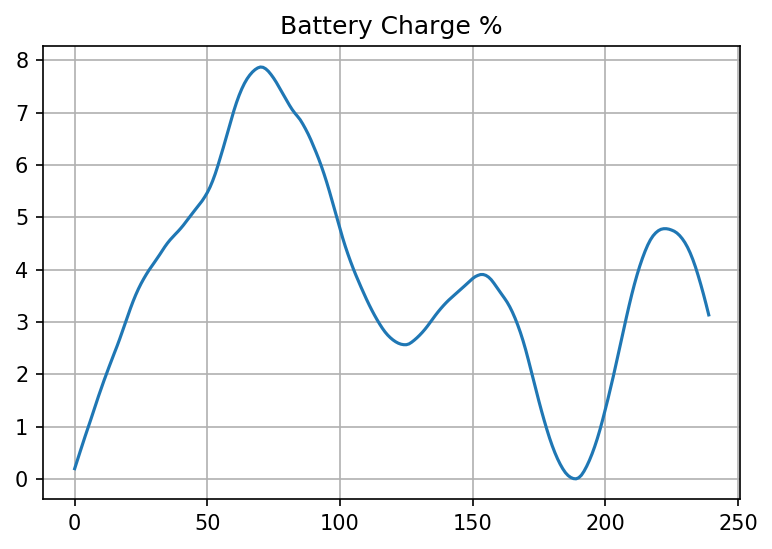

In [14]:
plt.figure(400, dpi=150)#, facecolor='w', edgecolor='k')
# plt.plot(Bt.value)
# plt.plot(Bt.value-L*regD)
plt.plot((100/E_max)*(-E_init + np.cumsum(-Bt.value)))
plt.title('Battery Charge %')
plt.grid(True)  
plt.show()

In [16]:
np.array_equal(np.dot(Add_mat,Bt.value),np.cumsum(Bt.value))

False

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go

In [ ]:
# dhttps://plot.ly/python/range-slider/
# Create a trace
trace = go.Scatter(
    x = np.linspace(0, 1, T),
    y = Bt.value
)

data = [trace]

# layout = dict(
#     title='Time series with range slider and selectors',
#     xaxis=dict(
#         rangeselector=dict(
#             buttons=list([
# #                 dict(count=1,
# #                      label='4s',
# #                      step='seconds',
# #                      stepmode='backward'),
#                 dict(count=1,
#                      label='1m',
#                      step='mins',
#                      stepmode='backward'),
#                 dict(count=10,
#                     label='1h',
#                     step='hour',
#                     stepmode='todate'),
#                 dict(count=60,
#                     label='6h',
#                     step='hour',
#                     stepmode='backward'),
#                 dict(step='all')
#             ])
#         ),
#         rangeslider=dict(
#             visible = True
#         ),
#         type='date'
#     )
# )

py.iplot(data, filename='basic-line')

# fig = dict(data=data, layout=layout)
# py.iplot(fig)

In [ ]:
# Bt is discharge - charge
# t0 = time.time()
At = cp.Variable((T, 5))
# epsilon = cp.Variable((T, 1))
# # ob = cp.Variable()
objective = cp.Minimize(sum(abs(At)))
# objective = cp.Minimize(np.max(np.dot(Sub_mat,Xt)))
# objective = cp.Minimize(np.max(np.multiply(Sub_mat,Xt)))
constraints = [abs(Bt-L*regD) <= epsilon,
               Bt[0] == E_init,
               -P_max <= Bt,
               Bt <= P_max,
#               Add_mat@(-Bt) + E_init <= E_max,
#               0*E_max <= Add_mat@(-Bt)]
              0*E_max <= Add_mat@(-Bt),
               Add_mat@(-Bt) <= E_max]

prob = cp.Problem(objective, constraints)
prob.solve()  # Returns the optimal value.
t1 = time.time()
print('Elapsed time:',t1-t0)
print("status:", prob.status)
print("optimal value", prob.value)
# print("optimal var", Bt.value)